In [8]:
class Models:
    def __init__(self,β:float,γ:float,rent:float,y1:float,y2:float,y3:float,tran:"np.ndarray[np.float64]",endow:"np.ndarray[np.float64]",na:int,ny:int,a_max:float,a_min:float,grid_a:"np.ndarray[np.float64]"):
        # パラメータ
        self.β = β # 割引因子
        self.γ = γ # 相対的危険回避度

        # 要素価格
        self.rent = rent # 純利子率

        # 労働所得
        self.y1 = y1
        self.y2 = y2
        self.y3 = y3

        # リスク
        self.tran = tran
        self.endow = endow

        # グリッド
        self.na = na # 貯蓄グリッドの数
        self.ny = ny # 所得グリッドの数
        self.a_max = a_max # 貯蓄グリッドの最大値
        self.a_min = a_min # 貯蓄グリッドの最小値 
        self.grid_a = grid_a # 貯蓄グリッド

In [9]:
def Calibration():
    # パラメータはここで設定をする
    β = 0.985**20
    γ = 2.0
    rent = 1.025**20 - 1.0
    y1 = 1.0
    y2 = 1.2
    y3 = 0.4

    tran = np.array([[0.7451,0.2528,0.0021], [0.1360,0.7281,0.1360], [0.0021,0.2528,0.7451]])
    endow = np.array([0.8027, 1, 1.2457])
    ny = 3

    na = 21
    a_max = 2.0
    a_min = 0.0

    grid_a = np.linspace(a_min,a_max,na)

    return Models(β, γ, rent, y1, y2, y3, tran, endow, na, ny, a_max, a_min, grid_a)

In [10]:
def mu_CRRA(cons,γ):
    return cons**(-γ)

In [11]:
# 使う関数を呼び出す
import numpy as np # 配列を扱うためのパッケージ
import matplotlib.pyplot as plt # プロットを行うためのパッケージ
import japanize_matplotlib # プロットで日本語を使うためのパッケージ
from scipy import optimize # Python上の Optimization Tool
from scipy import interpolate # Python上の Interpolation Tool

## リスクの導入

- RBCモデルやニューケインジアンDSGEモデルでは、全要素生産性(total factor productivity, TFP)ショックや金融政策ショックといった外生的なショックが景気循環のドライビングファクターであると考える。あるいは、各家計も所得変動や健康状態等のリスクに直面している。


- そのため、経済変数のいくつかは確率変数になるかもしれない。その場合、経済主体は生涯効用の期待値を最大化するように意思決定を行っていると考える。

- 再び3期間モデルを考えよう。経済主体は不確実性に直面していて、生まれたときの労働賦与量(labor endowment)が異なるとする。すなわち、$(y_{1},y_{2})$が変化し得る。また、$y_{2}$は$y_{1}$に依存する形で確率的に決定するものとする。


- 具体的には、$(y_{1},y_{2})$はそれぞれ、以下の離散的な値のいずれかを取るものとする。

$$
  y_{i} \in \{y_{1},y_{2},\cdots,y_{n}\}
$$

- また、$y_{1}=y_{i}$が与えられたとき、$y_{2}=y_{j}$となる確率は、以下の遷移行列(transition matrix)で与えられる:

$$
  \Pi = \left[
\begin{matrix} 
\pi_{1,1} & \pi_{1,2} & \cdots & \pi_{1,n} \\
\vdots & \vdots & \cdots & \vdots \\
\pi_{n,1} & \pi_{n,2} & \cdots & \pi_{n,n}
\end{matrix}
\right]
$$

ここで、$\pi_{i,j}$は、$y_{1}=y_{i}$が与えられたとき、$y_{2}=y_{j}$となる条件付き確率である。

- 労働所得に不確実性を導入したことによって、モデルを解く際に何が変わったのであろうか。


- 第1に状態変数の数が1つ増えるという違いがある。すなわち、生産関数は$a'=g(a,y)$のように2変数の関数となる。これは若年期の意思決定を行う際に、現在の資産$a$だけでなく、労働所得$y$に依存して予算が変わり、意思決定も影響を受けるためである。


- 中年期から老年期にかけての一階条件は、これまでと同じく、

$$
  u'(y_{2,j}+(1+r)a_{2,i}-a_{3}) = \beta (1+r) u'(y_{3}+(1+r)a_{3}) \tag{1}
$$

となる。老年期の年金$y_{3}$にはリスクがない点に注意。この式を解くことで、$a_{3}=g(a_{2,i},y_{2,j})$を得る。

- 第2の変更点として、若年期において次期の労働所得が不確実であることから、期待効用(expected utility)を計算する必要が出てくる。このため若年期から中年期にかけての一階条件は、

$$
  u'(y_{1,j}+a_{1,i}-a_{2}) = \beta (1+r) \mathbb{E} u'(y_{2}+(1+r)a_{2}-a_{3}) \\
  = \beta (1+r) \mathbb{E} u'(y_{2}+(1+r)a_{2}-g(a_{2},y_{2}))
$$

となる。

- 条件付き確率を用いると、右辺の期待値は以下のように書くことができる。

$$
  u'(y_{1,j}+a_{1,i}-a_{2}) = \\
  \beta (1+r) \sum_{k=1}^{n} \pi_{j,k} u'(y_{2,k}+(1+r)a_{2}-g(a_{2},y_{2,k})) \tag{2}
$$


- アルゴリズム


1. 3期間モデルにあわせてパラメータを再設定する。所得リスクのパラメータをカリブレートする。

2. $a_{2,i} \in \{a_{2,1},\dots,a_{2,I}\}$を離散化した第2期の資産とする。

3. 各$(a_{2,i},y_{2,j})$について、(1)式を解くような$a_{3}$を探し出す。所得リスクの存在によって状態変数が一つ増えた（＝ループが多重になった）点に注意してほしい。

4. $a_{2,i} \in \{a_{2,1},\dots,a_{2,I}\}$を離散化した第1期の資産とする。

5. $a_{3}=\tilde{g}(a_{2},y_{2})$を近似する内挿法を一つ定める。

6. ステップ3で得た中年期の貯蓄関数$a_{3}=\tilde{g}(a_{2})$を所与として、各$(a_{1,i},y_{1,j})$について、(2)式を解くような$a_{2}$を探し出す。

In [12]:
def resid_three_period2(a3,a2,e2,params):

    # オイラー方程式の左辺：中年期の限界効用
    # 予算制約の右辺に基づいて手持ちの現金(cash on hand)を定義
    coh = (1+params.rent)*a2 + params.y2*e2
    
    if coh - a3 > 0.0: # 消費が正値
        mu2 = mu_CRRA(coh-a3,params.γ)
    else:
        mu2 = 10000.0
    
    # 老年期の限界効用
    mu3 = mu_CRRA((1 + params.rent)*a3 + params.y3, params.γ)

    # 残差(residual)
    return params.β*(1.0 + params.rent)*(mu3/mu2) - 1.0

In [13]:
params = Calibration()

# 空っぽの変数を用意：policy functionの器
a2_nl = np.zeros((params.na, params.ny))

# 実際に各w_{i}のもとで、残差関数がゼロになるようなaを探す
for (y_ind,y_val) in enumerate(params.endow):
    for (a_ind,a_val) in enumerate(params.grid_a):
        
        # 1変数のfunctionにする
        resid_three_period21 = lambda a: resid_three_period2(a, a_val, y_val, params)

        # 0.01はゼロ点を探す際の初期値
        res = optimize.fsolve(resid_three_period21,x0=0.01)
        a2_nl[a_ind,y_ind] = res[0]

print(a2_nl)

[[0.24097756 0.3361025  0.45456271]
 [0.30681355 0.40193849 0.5203987 ]
 [0.37264954 0.46777449 0.58623469]
 [0.43848554 0.53361048 0.65207069]
 [0.50432153 0.59944647 0.71790668]
 [0.57015752 0.66528246 0.78374267]
 [0.63599351 0.73111846 0.84957866]
 [0.70182951 0.79695445 0.91541466]
 [0.7676655  0.86279044 0.98125065]
 [0.83350149 0.92862644 1.04708664]
 [0.89933748 0.99446243 1.11292263]
 [0.96517348 1.06029842 1.17875863]
 [1.03100947 1.12613441 1.24459462]
 [1.09684546 1.19197041 1.31043061]
 [1.16268146 1.2578064  1.3762666 ]
 [1.22851745 1.32364239 1.4421026 ]
 [1.29435344 1.38947838 1.50793859]
 [1.36018943 1.45531438 1.57377458]
 [1.42602543 1.52115037 1.63961057]
 [1.49186142 1.58698636 1.70544657]
 [1.55769741 1.65282235 1.77128256]]


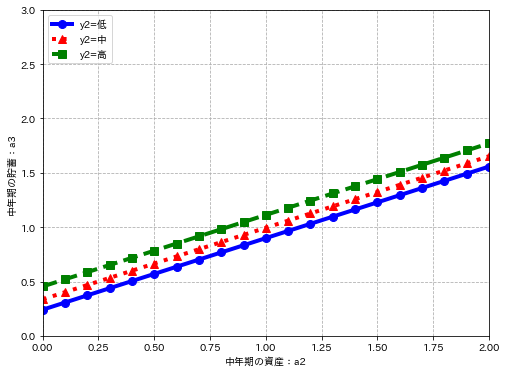

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.grid_a,a2_nl[:,0],c="b",marker="o",lw=4,ms=8,label="y2=低")
ax.plot(params.grid_a,a2_nl[:,1],c="r",ls=":",marker="^",lw=4,ms=8,label="y2=中")
ax.plot(params.grid_a,a2_nl[:,2],c="g",ls="--",marker="s",lw=4,ms=8,label="y2=高")
ax.set(xlabel="中年期の資産：a2",ylabel="中年期の貯蓄：a3",xlim=(0,2.0),ylim=(0,3.0))
ax.legend(loc="upper left")
ax.grid(ls="--")
plt.show()

In [15]:
def resid_three_period1(a2,a1,e1,a2_nl,params):

    # オイラー方程式の左辺：若年期の限界効用
    # 予算制約の右辺に基づいて手持ちの現金(cash on hand)を定義
    coh = (1 + params.rent)*a1 + params.y1*params.endow[e1]

    if coh - a2 > 0.0: # 消費が正値
        mu1 = mu_CRRA(coh-a2,params.γ)
    else:
        mu1 = 10000.0

    mu2 = np.zeros(params.ny)
    for i in range(params.ny):

        # 中年期の消費：線形補間：毎回係数を計算するのは時間の無駄なので本当は関数の外に出したほうがよい！
        interp1 = interpolate.interp1d(params.grid_a,a2_nl[:,i])
        cons = interp1(a1)
        
        # 中年期の限界効用
        mu2[i] = mu_CRRA(cons, params.γ)

    # 残差(residual)
    exp_val = np.dot(params.tran[e1, :], mu2)

    return params.β*(1.0 + params.rent)*(exp_val/mu1) - 1.0

In [16]:
# 空っぽの変数を用意：policy functionの器
a1_nl = np.zeros((params.na, params.ny))

# 実際に各w_{i},y_{j}のもとで、残差関数がゼロになるようなaを探す
for (y_ind,y_val) in enumerate(params.endow):
    for (a_ind,a_val) in enumerate(params.grid_a):
        
        # 1変数のfunctionにする
        resid_three_period11 = lambda a: resid_three_period1(a, a_val,y_ind,a2_nl,params)

        # 0.01はゼロ点を探す際の初期値
        res = optimize.fsolve(resid_three_period11,x0=0.01)
        a1_nl[a_ind,y_ind] = res[0]

print(a1_nl)

[[0.56870207 0.70434486 0.87097815]
 [0.6715658  0.80618346 0.97331444]
 [0.77475668 0.90870678 1.07611829]
 [0.87815549 1.01163135 1.17922016]
 [0.98169439 1.11481332 1.28252383]
 [1.08533207 1.2181712  1.3859705 ]
 [1.18904197 1.32165512 1.48952222]
 [1.29280626 1.42523266 1.59315334]
 [1.39661251 1.52888178 1.69684596]
 [1.50045182 1.63258692 1.80058717]
 [1.60431762 1.73633679 1.90436742]
 [1.70820499 1.84012294 2.00817954]
 [1.81211014 1.94393898 2.11201798]
 [1.91603013 2.04777991 2.21587843]
 [2.01996263 2.15164181 2.31975746]
 [2.12390577 2.25552156 2.42365233]
 [2.22785804 2.35941661 2.52756079]
 [2.3318182  2.46332489 2.63148103]
 [2.43578523 2.56724469 2.73541151]
 [2.53975827 2.67117458 2.83935098]
 [2.6437366  2.77511335 2.94329836]]


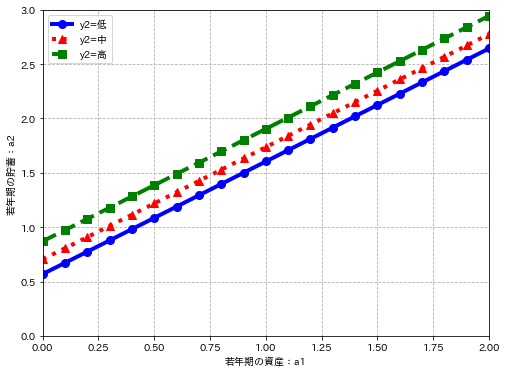

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(params.grid_a,a1_nl[:,0],c="b",marker="o",lw=4,ms=8,label="y2=低")
ax.plot(params.grid_a,a1_nl[:,1],c="r",ls=":",marker="^",lw=4,ms=8,label="y2=中")
ax.plot(params.grid_a,a1_nl[:,2],c="g",ls="--",marker="s",lw=4,ms=8,label="y2=高")
ax.set(xlabel="若年期の資産：a1",ylabel="若年期の貯蓄：a2",xlim=(0,2.0),ylim=(0,3.0))
ax.legend(loc="upper left")
ax.grid(ls="--")
plt.show()